# Welcome to the Dask ML Tutorial Session in Domino!

## Purpose of this notebook
This notebook uses a K-Means clustering example to demonstrate how to use Dask ML with a Domino On-Demand Dask cluster. It requires having Dask ML installed both the workspace compute environment and the cluster worker compute environment (see the README for details).

## Contents of this notebook
This notebook aims to demonstrate the same K-Means calculation both without Dask and with Dask. Below are the expected benchmarks, assuming a Dask cluster with 3 workers and a Hardware Tier selection with 1 core and 4GB RAM for all components. Note that the `k-means||` algorithm (used by default in `dask-ml`) can actually be slower than the `k-means++` algorithm (used by default in `sklearn`), but has the advantage that it does not need to read the entire dataset into memory on a single machine.

1. Compute k-means clustering on some synthetic data without Dask - 25s
2. Do the same computation using Dask ML on Domino On-Demand cluster nodes - 30s

The Dask example was taken from https://examples.dask.org/machine-learning.html.

## 1. K-Means clustering without Dask

In [1]:
import time
from sklearn import datasets
from sklearn import cluster
import matplotlib.pyplot as plt
%matplotlib inline

Total fit time: 23.51 s


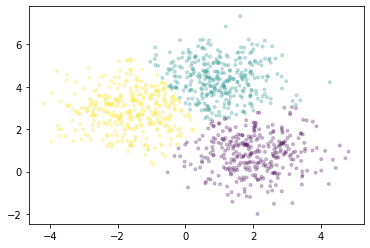

In [2]:
# You can change these variables for N_SAMPLES and N_PLOT to try larger or smaller amounts of data
N_SAMPLES = 10**7
N_PLOT = 10**4

X, y = datasets.make_blobs(n_samples=N_SAMPLES,
                           random_state=0,
                           centers=3)

t1 = time.time()
km = cluster.KMeans(n_clusters=3, n_init=5)
km.fit(X)
t2 = time.time()
print(f"Total fit time: {round(t2 - t1, 2)} s")

fig, ax = plt.subplots()
ax.scatter(X[::N_PLOT, 0], X[::N_PLOT, 1], marker='.', c=km.labels_[::N_PLOT],
           cmap='viridis', alpha=0.25)

## 2. K-Means clustering with Dask ML on Domino On-Demand cluster nodes

While running this section, we recommend exploring the **Dask Web UI**, especially the **Task Stream**. This is also where you may see warnings or errors if there are any issues with the dask installation in your Compute Environments, e.g. mismatched versions between the workspace environment and the cluster worker environment. **Troubleshooting note**: If you see any errors from the Dask workers, you may also find it useful to view the **logs** for each worker on the **Info** page in the Dask Web UI.

### Connecting to the cluster
The code snippet below is taken from https://docs.dominodatalab.com/en/5.0.2/reference/dask/Working_with_your_cluster.html, and connects you to the On-Demand Dask cluster configured for your Domino workspace.

In [3]:
from dask.distributed import Client
import os

service_host = os.environ["DASK_SCHEDULER_SERVICE_HOST"]
service_port = os.environ["DASK_SCHEDULER_SERVICE_PORT"]
client = Client(address=f"{service_host}:{service_port}")

# you should now be connected to the cluster
# Dashboard link from the client object is clickable but will not route in Domino
# Use the embedded Dask Web UI tab instead

# You can also expand the "Scheduler Info" in the client object to see some cluster information
client

<Client: 'tcp://10.0.51.249:8786' processes=3 threads=3, memory=12.00 GiB>

### Modifying the K-Means clustering code to use Dask ML
Notice the following modifications:
* The `make_blobs` function comes from `dask_ml` rather than `sklearn`, and requires an additional argument `chunks` which can [impact performance](https://docs.dask.org/en/latest/array-chunks.html). This function returns dask array objects rather than standard pandas/numpy objects.
* Adding `X.persist()` to dask arrays where possible can [improve performance](https://docs.dask.org/en/latest/best-practices.html?highlight=persist#persist-when-you-can).
* The `KMeans` clustering algorithm also comes from `dask_ml` rather than `sklearn` and has some additional arguments. Note that there are actual differences in the underlying algorithm to enable parallelization and scaling; see [the docs](https://ml.dask.org/modules/generated/dask_ml.cluster.KMeans.html#dask_ml.cluster.KMeans) for details.

In [4]:
import time
import dask_ml.datasets
import dask_ml.cluster
import matplotlib.pyplot as plt
%matplotlib inline

Total fit time: 30.24 s


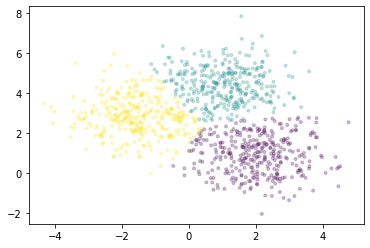

In [5]:
# You can change these variables for N_SAMPLES and N_PLOT to try larger or smaller amounts of data
N_SAMPLES = 10**7
N_PLOT = 10**4

X, y = dask_ml.datasets.make_blobs(n_samples=N_SAMPLES,
                                   chunks=N_SAMPLES/10,
                                   random_state=0,
                                   centers=3)
X = X.persist()

t1 = time.time()
km = dask_ml.cluster.KMeans(init='k-means||', n_clusters=3, init_max_iter=5, oversampling_factor=10)
km.fit(X)
t2 = time.time()
print(f"Total fit time: {round(t2 - t1, 2)} s")

fig, ax = plt.subplots()
ax.scatter(X[::N_PLOT, 0], X[::N_PLOT, 1], marker='.', c=km.labels_[::N_PLOT],
           cmap='viridis', alpha=0.25);

## Further Reading

This is a high-level overview demonstrating some the components of Dask-ML.
Visit the main [Dask-ML](http://ml.dask.org) documentation, see the [dask tutorial](https://github.com/dask/dask-tutorial) notebook 08, or explore some of the other machine-learning examples from [here](https://examples.dask.org/machine-learning.html).